# Introduction

by Arvin Assanny 

### Dataset Description

This dataset is a collection of 2,000 Bike and Car images, which we obtain from [Kaggle.](https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset)

This dataset also have two labels, which is Bike and Cars, so it is considered as binary. Almost all the 2000 images are unique. Also in this project we will use base model and a pre-trained model.

### Background
A parking company requested us to build a model to predict a motorbike and car whenever they enter their's parking ground. This needed to be done because they wanted to make a automation so the customers do not need to pick a ticket and the fare for their parkings will be decided by their type of vehicle.

### Problem Statement
Predict an image classification of a motorbike and car using deep learning model.

## Import Library

Here we import all the library we needed. 

We use splitfolders to split our dataset into train, validation, and test sets. 

In [1]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#For Data Manipulation
import numpy as np
import pandas as pd
from IPython.display import clear_output as cls
from collections import Counter

#For Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import imshow
%matplotlib inline

# For Modeling Artificial Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Dropout, Conv2D, AveragePooling2D, Flatten, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import splitfolders
import glob
import cv2
import os

#For Model Evaluation 
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, accuracy_score
import itertools

#Saving Model
import pickle

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

#Set random seed
np.random.seed(813)
tf.random.set_seed(813)

## Data Loading
Using Kaggle dataset and we connect it with our Google Colab, after that we unzip the dataset so we can use it for our project.

In [3]:
from google.colab import files
!pip install -q kaggle
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json
total 4
-rw------- 1 root root 68 Feb 11 11:21 kaggle.json
{"username":"arvinassanny","key":"1041c7d65b624970e731eb4a58099244"}

In [4]:
!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset

100% 103M/103M [00:05<00:00, 24.5MB/s]
100% 103M/103M [00:05<00:00, 19.5MB/s]


In [5]:
!unzip -q /content/car-vs-bike-classification-dataset.zip

Now our dataset is ready.

### Data Split

Since the data was not splitted into train,val,and test dataset. We will use this package to do so, here we use 80% for training and 10% each for validation and test

In [6]:
splitfolders.ratio("Car-Bike-Dataset", output="dataset-output", seed=813, ratio=(0.8,0.1,0.1), group_prefix=None)

Copying files: 4000 files [00:01, 2728.95 files/s]


In [7]:
df_total = {'CAR': [2000], 'BIKE': [2000]}
df_total = pd.DataFrame(data=df_total)

We have 4000 image.

### Assign image into folders

In [8]:
Bike_train= r'/content/dataset-output/train/Bike'
Car_train= r'/content/dataset-output/train/Car'
dirlist=[Bike_train, Car_train]
classes=['Bike', 'Car']
filepaths=[]
labels=[]
for d,c in zip(dirlist, classes):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   classes: ', len(classes))

filepaths:  3200    classes:  2


Here we can see that we have 3200 data in our train set.

## Exploratory Data Analysis

Now we want to know more about our data, we also want to make some visualization.

In [9]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(3200,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

Bike    1600
Car     1600
Name: labels, dtype: int64


Looks like we have a balanced data.

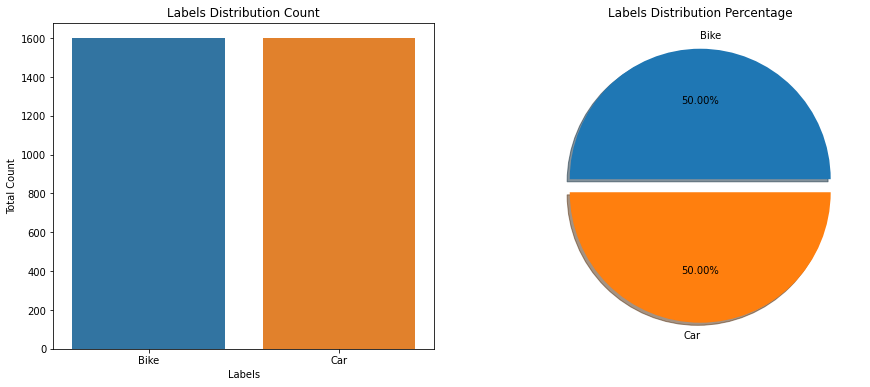

In [10]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x='labels', data=df)
plt.title('Labels Distribution Count')
fig.set_xticklabels(['Bike','Car'])
plt.xlabel('Labels')
plt.ylabel('Total Count')
plt.subplot(1, 2, 2)
plt.pie(df.labels.value_counts(), labels=['Bike','Car'], autopct='%1.2f%%', explode=[0.05, 0.05], shadow=True)
plt.title('Labels Distribution Percentage')
plt.show()

This confirmed that our data is indeed balanced, so for our evaluation we can use accuracy metrics.

Here we see on our train set, we have 1600 image with bike label and 1600 image with car label.

Next, we will show our bikes and cars image.

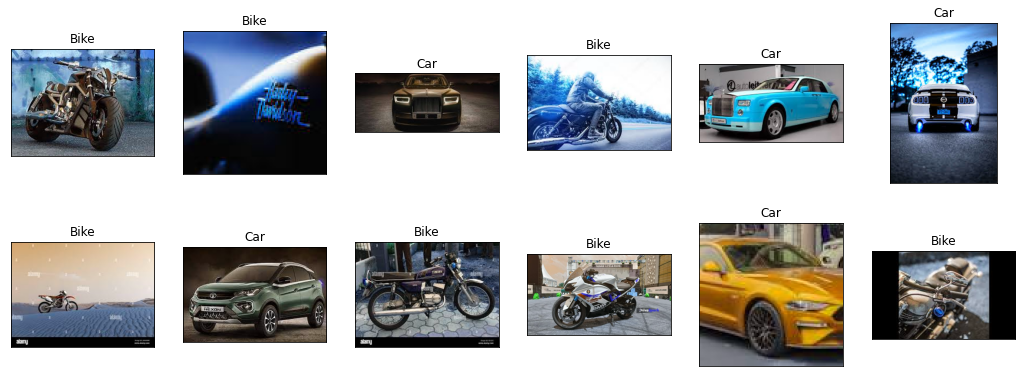

In [11]:
# Show our image data
plt.figure(figsize=(18,10))
for i in range(12):
    random = np.random.randint(1,len(df))
    plt.subplot(3,6,i+1)
    plt.imshow(cv2.imread(df.loc[random,"file_paths"]))
    plt.title(df.loc[random, "labels"], size = 12, color = "black") 
    plt.xticks([])
    plt.yticks([])

plt.show()

## Data Preprocessing

Now we want to prepare our data so our model can find the patern to predict our sample better.

In [12]:
train_path = r"/content/dataset-output/train"
test_path = r"/content/dataset-output/test"
val_path = r"/content/dataset-output/val"

First we will assign our data set from splitfolder into train,test,val path for our data preprocessing

### Data Augmentation and Rescaling

We ImageDataGenerator to do our data preprocessing, which we will use to rotation, scaling, and flipping our image dataset. We will only use this on our train and validation set only. For our test set we only do rescaling.

In [13]:
# Define our conditions
dataAugmentaion = ImageDataGenerator(rescale=1/255.,
                               rotation_range = 90,
                               zoom_range = 0.20,
                               width_shift_range = 0.1,
                               shear_range=0.2,
                               fill_mode = "nearest",
                               horizontal_flip = True,
                               vertical_flip = True
                               )

train_set = dataAugmentaion.flow_from_directory(train_path, 
                               class_mode = 'binary', 
                               target_size = (128,128), 
                               shuffle = True, 
                               batch_size = 32
                               )
val_set = dataAugmentaion.flow_from_directory(val_path,
                               class_mode = 'binary', 
                               target_size = (128,128),
                               shuffle = False, 
                               batch_size = 32
                               )
# For test set, only use resacling
rescaling = ImageDataGenerator(rescale=1/255.)
test_set = rescaling.flow_from_directory(test_path,
                               class_mode = 'binary', 
                               target_size = (128,128),
                               shuffle = False, 
                               batch_size = 32
                               )

Found 3200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


We perform data augmentation on the training and validation datasets, while only rescaling the test data. We do this to help our model gain a better performance and reduce overfitting. Where for the test set, we only want to standarize the pixel value.

We also set our image size into 128x128, and set the batch size into 32.

In [14]:
# Check each set shape
train_counter = Counter(train_set.classes)
val_counter = Counter(val_set.classes)
test_counter = Counter(test_set.classes)
print(train_counter.items())
print(val_counter.items())
print(test_counter.items())

dict_items([(0, 1600), (1, 1600)])
dict_items([(0, 200), (1, 200)])
dict_items([(0, 200), (1, 200)])


We have a balanced dataset.

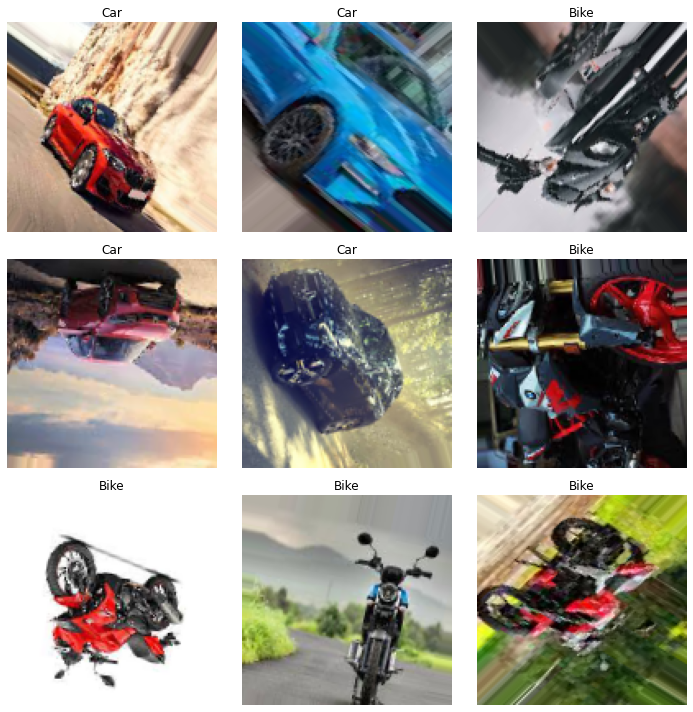

In [15]:
# Visualize our augmented dataset.
class_names_t = ["Bike", "Car"]
n_images = 10
plt.figure(figsize=(10, 10))
# DictionaryIterator
images, labels = train_set.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names_t[labels[i].astype("uint8")])
    plt.axis("off")
    i+=1
    if i>=(n_images+1):
        break
plt.tight_layout()
plt.show()

This is some random samples from our preprocessed images.

## Model Definition

Here we will define our model for this project, We use CNN with some baseline model. We will also make a improved model using a pre-trained model.

### Base Model

In [16]:
#clears the session
keras.backend.clear_session()

Now we will build our model. Here we use (128,128, 3) to be our input which shows that we have RGB image. After that, since this is a binary classfication we will use sigmoid in our output layer.

In [17]:
model = Sequential([
    layers.InputLayer(input_shape=(128,128, 3)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0

Here using some baseline CNN layers, we managed to have 4,624,193 trainable params.

After that we make our model complier and define earlystop,

In [18]:
model.compile(
  optimizer='adam',
  loss="binary_crossentropy",
  metrics=['accuracy'])

In [19]:
earlystop = EarlyStopping(monitor='val_loss',
                          patience=3)

### Base Model Training

Now we want to train our model

In [20]:
history = model.fit(train_set, validation_data=val_set, epochs=60, steps_per_epoch=20, callbacks=[earlystop], shuffle = True)

Epoch 1/60
20/20 [==============================] - 24s 395ms/step - loss: 0.7054 - accuracy: 0.5031 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/60
20/20 [==============================] - 9s 427ms/step - loss: 0.6936 - accuracy: 0.4828 - val_loss: 0.6922 - val_accuracy: 0.4975
Epoch 3/60
20/20 [==============================] - 9s 442ms/step - loss: 0.6917 - accuracy: 0.5359 - val_loss: 0.6886 - val_accuracy: 0.5025
Epoch 4/60
20/20 [==============================] - 7s 363ms/step - loss: 0.6845 - accuracy: 0.5281 - val_loss: 0.6782 - val_accuracy: 0.5400
Epoch 5/60
20/20 [==============================] - 8s 387ms/step - loss: 0.6716 - accuracy: 0.5281 - val_loss: 0.6767 - val_accuracy: 0.5275
Epoch 6/60
20/20 [==============================] - 8s 434ms/step - loss: 0.6767 - accuracy: 0.5312 - val_loss: 0.6760 - val_accuracy: 0.5350
Epoch 7/60
20/20 [==============================] - 8s 405ms/step - loss: 0.6765 - accuracy: 0.5656 - val_loss: 0.6725 - val_accuracy: 0.5650
Epoch

Now we want to visualize our train result

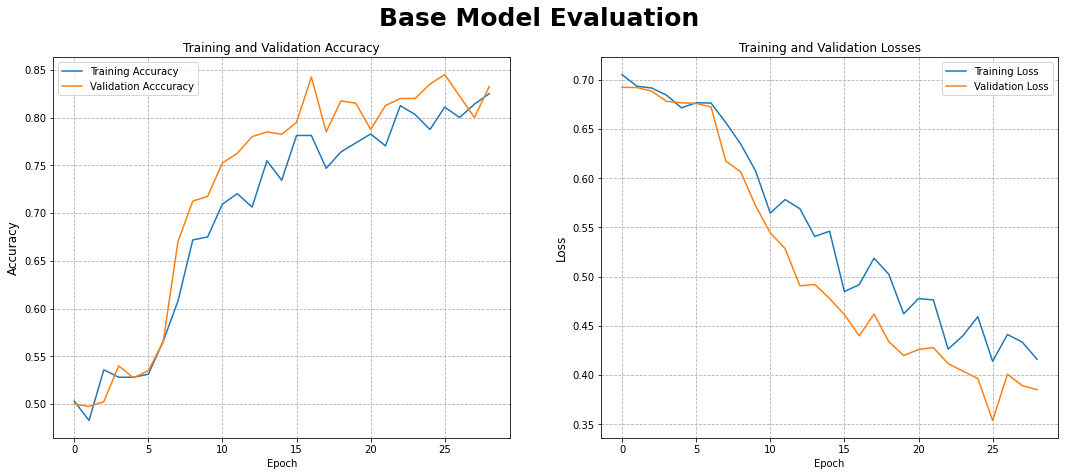

In [21]:
fig, ax = plt.subplots(1,2, figsize=(18,7))
fig.suptitle('Base Model Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history.history['accuracy'],label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch')
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel('Epoch')
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

Here is our result using some convolutional layers. Our result show a 0.82 accuracy and 0.4 loss. This model is not too bad, but we want our model to have higher accuracy and more consistent performace. With this model we need 29 epoch before it called back.

In this model we use 3 convolutional layers and 2 hidden layers, this model slighly overfitting, and we believe the score can be higher.

## Model Improvement

Now onto the improved model, which we will build using pre-trained model for transfer learning.

Transfer learning is a technique in deep learning where a model that has been trained on one task can be reused or fine-tuned for another related task. 

In [22]:
tf.keras.backend.clear_session()

Here we use ResNet50V2, which is an improvement over the original ResNet-50 architecture, with some modifications to the network design that improved its accuracy and reduced overfitting. 

In [23]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(128, 128,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )
base_model.trainable = False

94668760/94668760 [==============================] - 5s 0us/step


For this transfer learning, we set the input size of the images that the model will be working with to (128, 128, 3), meaning that the images will have 128 pixels in height and width, and 3 color channels.

We also set the trainable attribute of the model to False, meaning that the model's weights will not be updated during training.

In [24]:
model_improve = Sequential([
  base_model,
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(), 
  layers.Dense(256, activation='leaky_relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid') #Output Layer
])

model_improve.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 2048)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

Here we also add some flaten layer and hidden layers, because our intial training was giving us so many overfitting results.

In [25]:
model_improve.compile(
  optimizer='adam',
  loss="binary_crossentropy",
  metrics=['accuracy'])

In [26]:
earlystop_2 = EarlyStopping(monitor='val_loss',
                          patience=4)

Here we already make our compiler and callbacks for our improve model.

### Improved Model Training
Now we will train our model.

In [27]:
history2 = model_improve.fit(train_set, validation_data=val_set, epochs=100, steps_per_epoch=20, callbacks=[earlystop_2], shuffle = True)

Epoch 1/100
20/20 [==============================] - 17s 553ms/step - loss: 1.6937 - accuracy: 0.8813 - val_loss: 0.6247 - val_accuracy: 0.9475
Epoch 2/100
20/20 [==============================] - 8s 413ms/step - loss: 1.3579 - accuracy: 0.9156 - val_loss: 0.4858 - val_accuracy: 0.9575
Epoch 3/100
20/20 [==============================] - 9s 441ms/step - loss: 1.2156 - accuracy: 0.9219 - val_loss: 0.7479 - val_accuracy: 0.9425
Epoch 4/100
20/20 [==============================] - 8s 407ms/step - loss: 0.8289 - accuracy: 0.9250 - val_loss: 0.8984 - val_accuracy: 0.9025
Epoch 5/100
20/20 [==============================] - 9s 468ms/step - loss: 0.9111 - accuracy: 0.9266 - val_loss: 0.4499 - val_accuracy: 0.9500
Epoch 6/100
20/20 [==============================] - 9s 466ms/step - loss: 0.6821 - accuracy: 0.9266 - val_loss: 0.4771 - val_accuracy: 0.9650
Epoch 7/100
20/20 [==============================] - 10s 488ms/step - loss: 0.7606 - accuracy: 0.9297 - val_loss: 0.5287 - val_accuracy: 0.94

We only need to do 13 epoch, now for more detail analysis below using our visualization

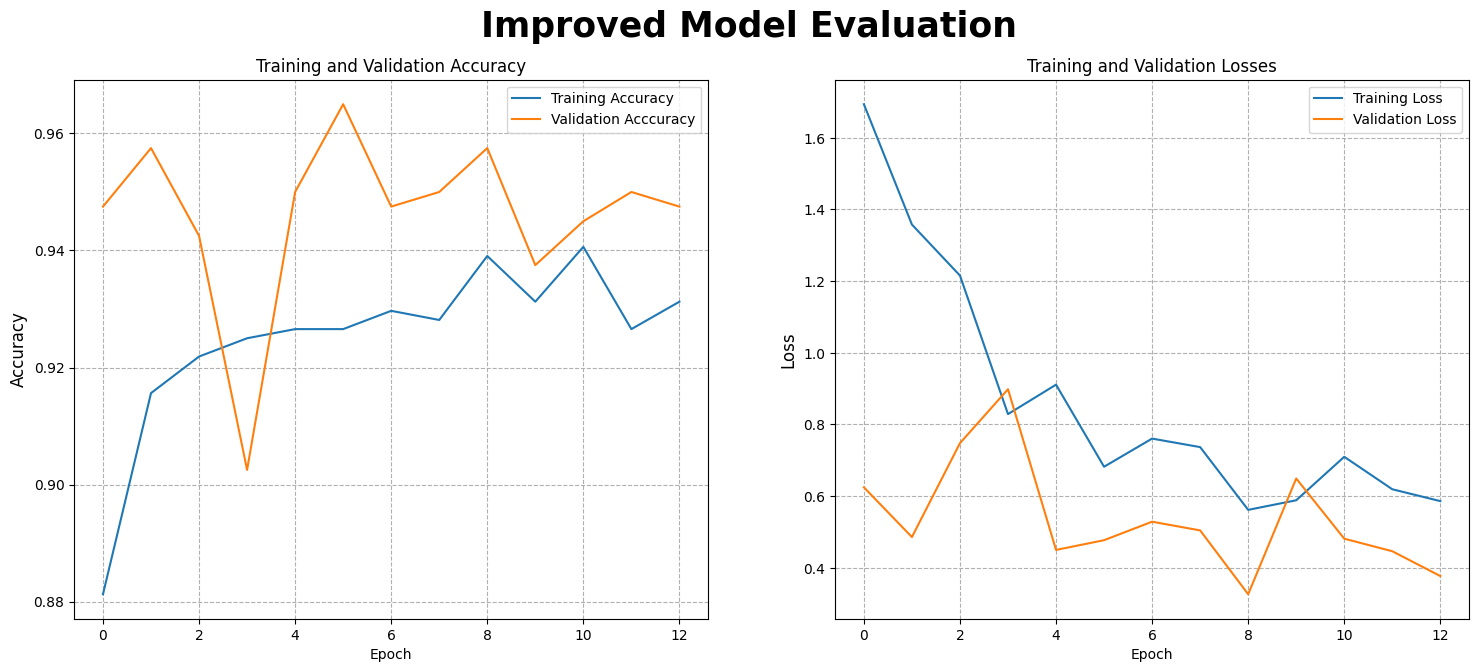

In [28]:
fig, ax = plt.subplots(1,2, figsize=(18,7))
fig.suptitle('Improved Model Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history2.history['accuracy'],label="Training Accuracy")
plt.plot(history2.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch')
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history2.history['loss'], label="Training Loss")
plt.plot(history2.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.xlabel('Epoch')
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

This model looks like has some gradient problems for exploding, but if we look closer the differences is not too far. The result shows that our model still overfitting a little bit, but we managed to gain higher accuracy with 0.96.

## Model Evaluation

Now we want to look deeper using some metrics to evaluate our model.

### Base Model Evaluation

In [29]:
loss, accuracy = model.evaluate(test_set)
print('Test accuracy :', accuracy)

13/13 [==============================] - 2s 172ms/step - loss: 0.3879 - accuracy: 0.8300
Test accuracy : 0.8299999833106995


Base model accuracy when evaluated with test set acquire 0.82 accuracy, which is a decent score.

Now, we want to look at classification report of this model.

In [30]:
# Fetch prediction
prob = model.predict(test_set)
predictions = prob.flatten()
predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy()

# Get the true labels from the test set
true_labels = test_set.labels

# Print Classification report
print(classification_report(true_labels, predictions))

# Print the AUC score
print('AUC Score:',roc_auc_score(true_labels, prob))

13/13 [==============================] - 3s 229ms/step
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       200
           1       0.92      0.72      0.81       200

    accuracy                           0.83       400
   macro avg       0.85      0.83      0.83       400
weighted avg       0.85      0.83      0.83       400

AUC Score: 0.9328


We have 83% accuracy, and since the dataset is balanced we can use this metrics. Accuracy can be a useful metric to evaluate the model's performance, as it measures the proportion of correctly classified samples over the total number of samples.

This would indicate that the model is able to correctly classify 83 out of 100 images, on average.

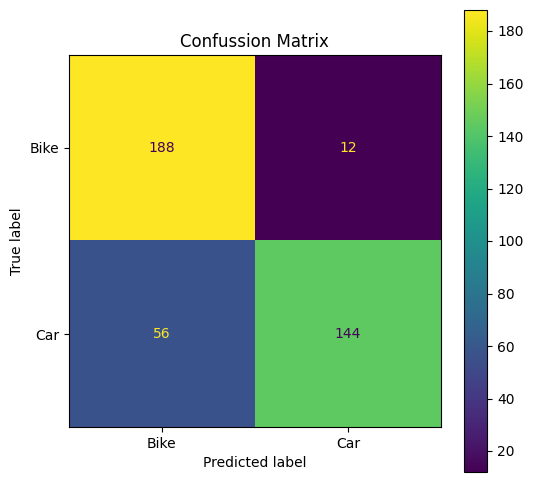

In [31]:
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names_t)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.title("Confussion Matrix")
plt.show()

Here using confussion matrix we can see our model perfomance in predicting a patern in bike and car. We know that our base model have some limitation in predicting car, because of higher result of mis-predict in predicting car.

1/1 [==============================] - 0s 112ms/step


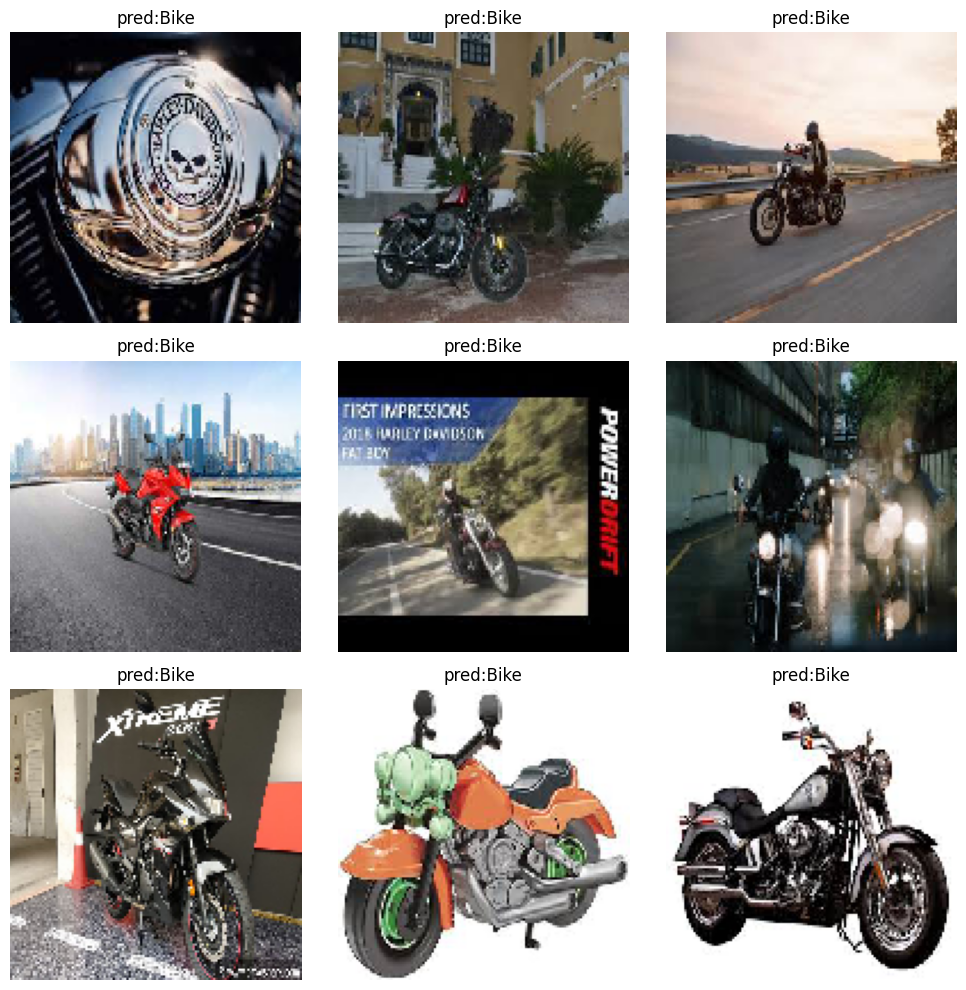

In [32]:
#Retrieve a batch of images from the test set
image_batch, label_batch = next(iter(test_set))
predictions = model.predict(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy()

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title('pred:%s' % class_names_t[predictions[i]])
  plt.axis("off")
plt.tight_layout()
plt.show()

Here we see performance of our model against test set. From this random result it looks like the model predicts all class right.

### Model Improved Evaluation
Now move on to the transfer learning model.

In [33]:
loss, accuracy = model_improve.evaluate(test_set)
print('Test accuracy :', accuracy)

13/13 [==============================] - 2s 182ms/step - loss: 0.0861 - accuracy: 0.9875
Test accuracy : 0.987500011920929


We have higher accuracy of 0.987, which is higher than our base-model.

In [34]:
# Fetch prediction
prob = model_improve.predict(test_set)
predictions = prob.flatten()
predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy()

# Get the true labels from the test set
true_labels = test_set.labels

# Print Classification report
print(classification_report(true_labels, predictions))

# Print the AUC score
print('AUC Score:',roc_auc_score(true_labels, prob))

13/13 [==============================] - 3s 180ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       200
           1       0.99      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

AUC Score: 0.999675


From this report, we know our model is almost perfect in predicting the image of bike and cars in our dataset. We have 0.99 accuarcy which translates into be able correctly classify 99 out of 100 images, on average, which is so good.

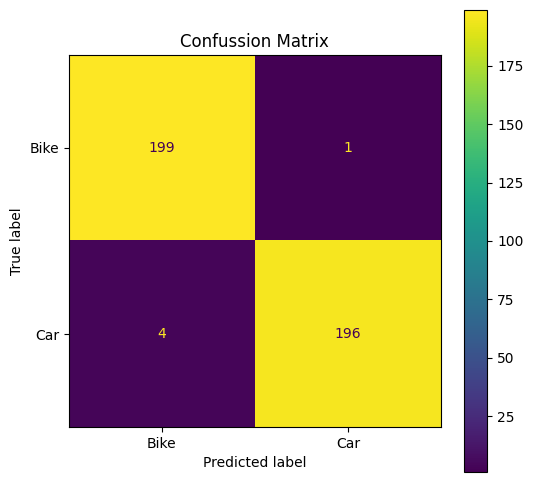

In [35]:
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names_t)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.title("Confussion Matrix")
plt.show()

From this model, we know that we have only 5 mis-predict out of 400 sample, this is a very good result.

1/1 [==============================] - 1s 1s/step


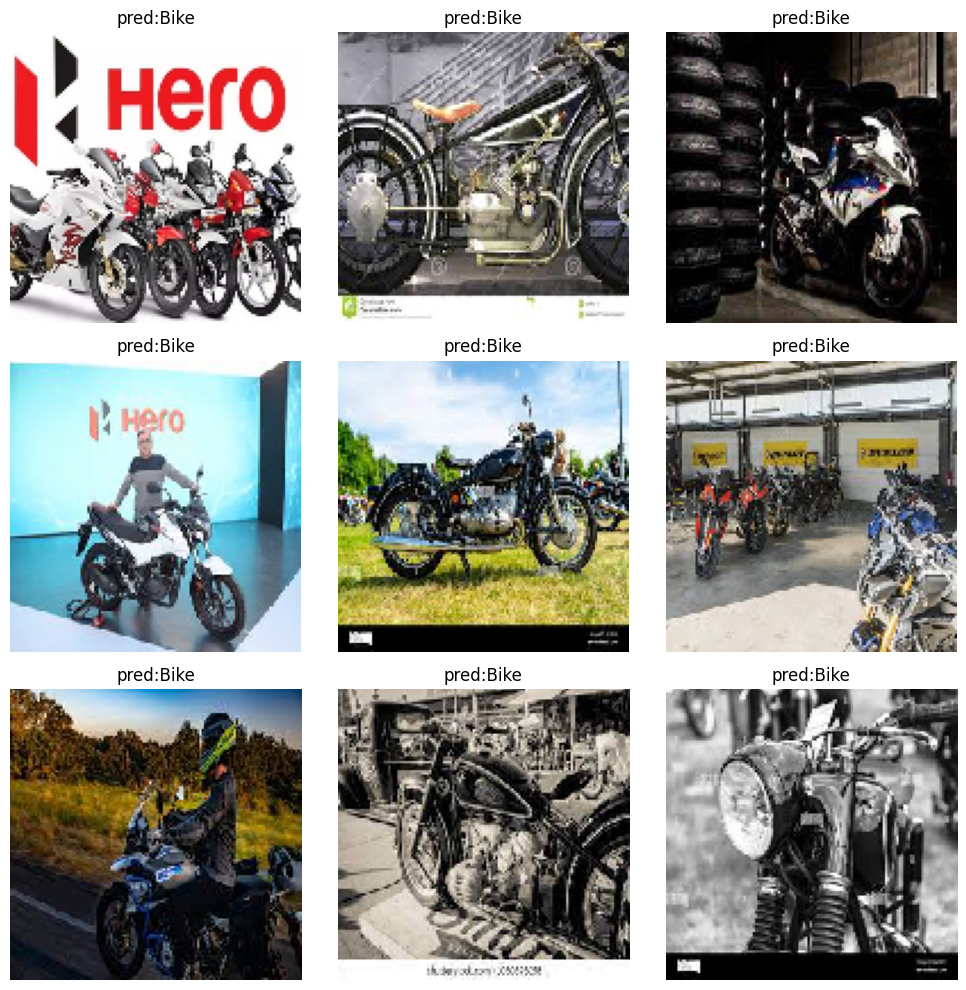

In [36]:
#Retrieve a batch of images from the test set
image_batch, label_batch = next(iter(test_set))
predictions = model_improve.predict(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy()

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title('pred:%s' % class_names_t[predictions[i]])
  plt.axis("off")
  i+=1
  if i>=(n_images+1):
    break
plt.tight_layout()
plt.show()

From this result, we also see a perfect prediction.

## Model Saving

Because of its higher accuarcy score and faster to train, we choose model_improve as our best model. This model will also be used in our inference data and deployment.

In [37]:
model_improve.save('model.h5')

## Overall Analysis & Conclusion

From our model evaluation, we can conclude that:
* We build 2 model, the first one using baseline model with some convolutional layers.The second using a pre-trained model and do some fine-tuning.
* Our Base model has a decent score with 83% accuracy, but still slightly overfitting.
* We successfully made a CNN model using transfer learning methode, which is ResNet50V2. The model final result have a 99% accuracy.
* We use accuracy because our model has a balanced target distribution as it measures the proportion of correctly classified samples over the total number of samples.
* We also do some preprocessing with our data, such as data augmentation and rescaling. This may be a factor why our model is so good.
* Our improved model probably slighlty overfitting, with a little degree of differences. Eventhough it may be a bestfitting since the result is very good.
* Improved model has a faster train time.
* In our preprocessing we make our data input into (128,128,3), this was done to prevent a problems because of our hardware limitation.
